In [1]:
# Multi-Domain Analysis of Preprocessing Effectiveness in Business Analytics
# A Benchmark Study of Data Characteristics and Performance Outcomes
# 
# Authors: [Your Name]
# Affiliation: [Your Institution]
# Target Journal: Journal of Business Analytics

import logging
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any, Callable, Protocol
from dataclasses import dataclass
from abc import ABC, abstractmethod
import json
import gc
import pickle
import os
import random
from itertools import combinations
from pathlib import Path
from typing import NamedTuple, Set

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.utils import resample
from statsmodels.stats.multitest import multipletests

# UCI ML Repository for dataset loading
try:
    from ucimlrepo import fetch_ucirepo
    UCI_AVAILABLE = True
    print("UCI ML Repository available")
except ImportError:
    UCI_AVAILABLE = False
    print("WARNING: ucimlrepo not available. Install with: pip install ucimlrepo")

warnings.filterwarnings('ignore')

# =============================================================================
# CELL 1: Configuration and Logging Setup
# =============================================================================

@dataclass
class StudyConfiguration:
    """Single Responsibility: Configuration management for the entire study"""
    random_state: int = 42
    test_size: float = 0.25
    n_iterations: int = 10
    cv_folds: int = 5
    significance_level: float = 0.05
    
    # Effect size thresholds (AUC differences)
    minimal_effect: float = 0.005  # 0.5%
    small_effect: float = 0.015    # 1.5%
    medium_effect: float = 0.025   # 2.5%
    large_effect: float = 0.035    # 3.5%
    
    # Data quality parameters
    high_quality_missing: float = 0.02   # 2%
    medium_quality_missing: float = 0.10  # 10%
    low_quality_missing: float = 0.25     # 25%
    
    def validate(self) -> None:
        """Validate configuration parameters"""
        assert 0 < self.test_size < 1, "Test size must be between 0 and 1"
        assert self.n_iterations > 0, "Iterations must be positive"
        assert 0 < self.significance_level < 1, "Significance level must be between 0 and 1"
        assert (self.minimal_effect < self.small_effect < 
                self.medium_effect < self.large_effect), "Effect sizes must be ordered"

def setup_logging() -> logging.Logger:
    """Single Responsibility: Logging system setup"""
    logger = logging.getLogger('preprocessing_study')
    logger.setLevel(logging.INFO)
    
    if not logger.handlers:
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    
    return logger

# Initialize global configuration and logger
config = StudyConfiguration()
config.validate()
logger = setup_logging()

np.random.seed(config.random_state)

logger.info(f"Study initialized at {datetime.now()}")
logger.info(f"Configuration: {config}")

print("=== MULTI-DOMAIN PREPROCESSING EFFECTIVENESS STUDY ===")
print(f"Timestamp: {datetime.now()}")
print(f"Random seed: {config.random_state}")
print(f"Effect size thresholds: {config.minimal_effect:.3f} (minimal) to {config.large_effect:.3f} (large)")

2025-09-04 19:19:50 - preprocessing_study - INFO - Study initialized at 2025-09-04 19:19:50.622905
2025-09-04 19:19:50 - preprocessing_study - INFO - Configuration: StudyConfiguration(random_state=42, test_size=0.25, n_iterations=10, cv_folds=5, significance_level=0.05, minimal_effect=0.005, small_effect=0.015, medium_effect=0.025, large_effect=0.035, high_quality_missing=0.02, medium_quality_missing=0.1, low_quality_missing=0.25)


UCI ML Repository available
=== MULTI-DOMAIN PREPROCESSING EFFECTIVENESS STUDY ===
Timestamp: 2025-09-04 19:19:50.623528
Random seed: 42
Effect size thresholds: 0.005 (minimal) to 0.035 (large)


In [2]:
# =============================================================================
# CELL 2: Enhanced Data Type Optimization Framework with Boolean Detection
# =============================================================================

class DataTypeOptimizer:
    """
    Single Responsibility: Optimize pandas DataFrame memory usage
    KISS: Simple, focused optimization without complex heuristics
    Enhanced with preserve_object_types parameter for stability
    """
    
    @staticmethod
    def detect_boolean_candidates(series: pd.Series) -> Tuple[bool, Dict[str, bool]]:
        """
        Detect if a series can be converted to boolean based on common patterns
        Returns: (is_boolean_candidate, mapping_dict)
        """
        # Get unique non-null values
        unique_values = series.dropna().unique()
        
        # Skip if more than 2 unique values
        if len(unique_values) > 2:
            return False, {}
        
        # Skip if only 1 unique value (constant column)
        if len(unique_values) <= 1:
            return False, {}
        
        # Convert to string for pattern matching
        str_values = [str(val).lower().strip() for val in unique_values]
        str_values_set = set(str_values)
        
        # Define boolean patterns based on common datasets
        boolean_patterns = [
            # Yes/No patterns (common in surveys, medical data)
            ({'yes', 'no'}, {'yes': True, 'no': False}),
            ({'y', 'n'}, {'y': True, 'n': False}),
            
            # True/False patterns
            ({'true', 'false'}, {'true': True, 'false': False}),
            ({'t', 'f'}, {'t': True, 'f': False}),
            
            # Numeric binary patterns
            ({'0', '1'}, {'0': False, '1': True}),
            ({'0.0', '1.0'}, {'0.0': False, '1.0': True}),
            
            # Positive/Negative patterns
            ({'positive', 'negative'}, {'positive': True, 'negative': False}),
            ({'pos', 'neg'}, {'pos': True, 'neg': False}),
            
            # Present/Absent patterns (common in medical/scientific data)
            ({'present', 'absent'}, {'present': True, 'absent': False}),
            ({'p', 'a'}, {'p': True, 'a': False}),
            
            # Success/Failure patterns
            ({'success', 'failure'}, {'success': True, 'failure': False}),
            ({'pass', 'fail'}, {'pass': True, 'fail': False}),
            
            # Active/Inactive patterns
            ({'active', 'inactive'}, {'active': True, 'inactive': False}),
            ({'on', 'off'}, {'on': True, 'off': False}),
            
            # High/Low patterns
            ({'high', 'low'}, {'high': True, 'low': False}),
            ({'h', 'l'}, {'h': True, 'l': False}),
            
            # Male/Female patterns (if appropriate for boolean representation)
            ({'male', 'female'}, {'male': True, 'female': False}),
            ({'m', 'f'}, {'m': True, 'f': False}),
            
            # Weekday/Weekend patterns
            ({'weekday', 'weekend'}, {'weekday': True, 'weekend': False}),
            
            # Common abbreviations
            ({'good', 'bad'}, {'good': True, 'bad': False}),
            ({'up', 'down'}, {'up': True, 'down': False}),
        ]
        
        # Check if values match any boolean pattern
        for pattern_set, mapping in boolean_patterns:
            if str_values_set == pattern_set:
                # Create reverse mapping for original case values
                original_mapping = {}
                for original_val in unique_values:
                    str_val = str(original_val).lower().strip()
                    if str_val in mapping:
                        original_mapping[original_val] = mapping[str_val]
                
                return True, original_mapping
        
        return False, {}
    
    @staticmethod
    def optimize_boolean_columns(df: pd.DataFrame, 
                               preserve_object_types: bool = False) -> Tuple[pd.DataFrame, List[str]]:
        """Convert appropriate columns to boolean type"""
        df_optimized = df.copy()
        converted_columns = []
        
        # Skip boolean optimization if preserve_object_types is True
        if preserve_object_types:
            return df_optimized, converted_columns
        
        for column in df_optimized.columns:
            col_data = df_optimized[column]
            
            # Skip if already boolean
            if col_data.dtype == 'bool':
                continue
            
            # Check if column is boolean candidate
            is_boolean, mapping = DataTypeOptimizer.detect_boolean_candidates(col_data)
            
            if is_boolean and mapping:
                try:
                    # Apply boolean conversion
                    df_optimized[column] = col_data.map(mapping).astype('bool')
                    converted_columns.append(column)
                    logger.info(f"Converted {column} to boolean: {mapping}")
                except Exception as e:
                    logger.warning(f"Boolean conversion failed for {column}: {str(e)}")
                    continue
        
        return df_optimized, converted_columns
    
    @staticmethod
    def optimize_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
        """Optimize numeric columns to smallest possible dtype"""
        df_optimized = df.copy()
        
        for column in df_optimized.select_dtypes(include=['int64', 'float64']):
            col_data = df_optimized[column]
            
            if col_data.dtype == 'int64':
                # Check if can fit in smaller int types
                c_min, c_max = col_data.min(), col_data.max()
                if c_min >= -128 and c_max <= 127:
                    df_optimized[column] = col_data.astype('int8')
                elif c_min >= -32768 and c_max <= 32767:
                    df_optimized[column] = col_data.astype('int16')
                elif c_min >= -2147483648 and c_max <= 32767:
                    df_optimized[column] = col_data.astype('int32')
            
            elif col_data.dtype == 'float64':
                # Try to convert to float32 if no precision loss
                converted = col_data.astype('float32')
                if np.allclose(col_data.values, converted.values, equal_nan=True):
                    df_optimized[column] = converted
        
        return df_optimized
    
    @staticmethod
    def optimize_categorical_columns(df: pd.DataFrame, 
                                   category_threshold: int = 50,
                                   preserve_object_types: bool = False) -> pd.DataFrame:
        """Convert string columns to category if beneficial"""
        df_optimized = df.copy()
        
        # Skip categorical optimization if preserve_object_types is True
        if preserve_object_types:
            return df_optimized
        
        for column in df_optimized.select_dtypes(include=['object']):
            unique_values = df_optimized[column].nunique()
            total_values = len(df_optimized[column])
            
            # Convert to category if less than 50% unique values
            if unique_values / total_values < 0.5 and unique_values < category_threshold:
                df_optimized[column] = df_optimized[column].astype('category')
                logger.info(f"Converted {column} to category: {unique_values} unique values")
        
        return df_optimized
    
    @classmethod
    def optimize_dataframe(cls, df: pd.DataFrame, 
                          preserve_object_types: bool = False) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Complete DataFrame optimization with comprehensive reporting
        
        Args:
            df: DataFrame to optimize
            preserve_object_types: If True, skip boolean and categorical optimizations
                                 for maximum stability during dataset loading
        """
        initial_memory = df.memory_usage(deep=True).sum() / 1024**2  # MB
        
        df_optimized = df.copy()
        
        # Step 1: Boolean optimization (most impactful for binary data)
        df_optimized, boolean_conversions = cls.optimize_boolean_columns(
            df_optimized, preserve_object_types
        )
        boolean_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
        
        # Step 2: Numeric optimization (always safe)
        df_optimized = cls.optimize_numeric_columns(df_optimized)
        numeric_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
        
        # Step 3: Categorical optimization
        df_optimized = cls.optimize_categorical_columns(
            df_optimized, preserve_object_types=preserve_object_types
        )
        final_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
        
        total_reduction = (initial_memory - final_memory) / initial_memory * 100 if initial_memory > 0 else 0
        boolean_reduction = (initial_memory - boolean_memory) / initial_memory * 100 if initial_memory > 0 else 0
        
        optimization_report = {
            'initial_memory_mb': initial_memory,
            'final_memory_mb': final_memory,
            'total_reduction_percent': total_reduction,
            'reduction_mb': initial_memory - final_memory,
            'boolean_conversions': boolean_conversions,
            'boolean_reduction_percent': boolean_reduction,
            'optimization_steps': {
                'boolean_memory_mb': boolean_memory,
                'numeric_memory_mb': numeric_memory,
                'categorical_memory_mb': final_memory
            }
        }
        
        if boolean_conversions and not preserve_object_types:
            logger.info(f"Boolean optimization: {len(boolean_conversions)} columns converted, "
                       f"{boolean_reduction:.1f}% memory reduction")
        
        logger.info(f"Memory optimization: {total_reduction:.1f}% reduction "
                   f"({initial_memory:.2f}MB → {final_memory:.2f}MB)")
        
        return df_optimized, optimization_report
      

# Test the enhanced optimizer with boolean cases
test_data = pd.DataFrame({
    'large_int': np.random.randint(0, 100, 1000),
    'float_data': np.random.random(1000),
    'yes_no_column': np.random.choice(['Yes', 'No'], 1000),
    'true_false_column': np.random.choice(['True', 'False'], 1000),
    'binary_numeric': np.random.choice([0, 1], 1000),
    'male_female': np.random.choice(['Male', 'Female'], 1000),
    'categories': np.random.choice(['Category_A', 'Category_B', 'Category_C'], 1000),
    'high_low': np.random.choice(['High', 'Low'], 1000),
    'active_inactive': np.random.choice(['Active', 'Inactive'], 1000)
})

print("ENHANCED DATA TYPE OPTIMIZATION TEST")
print("="*50)

print("\nBEFORE OPTIMIZATION:")
print(f"Memory usage: {test_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("Data types:")
for col in test_data.columns:
    unique_vals = test_data[col].unique()[:3]  # Show first 3 unique values
    print(f"  {col}: {test_data[col].dtype} (sample: {list(unique_vals)})")

optimized_test, report = DataTypeOptimizer.optimize_dataframe(test_data)

print(f"\nAFTER OPTIMIZATION:")
print(f"Memory usage: {report['final_memory_mb']:.2f} MB")
print(f"Total reduction: {report['total_reduction_percent']:.1f}%")
print(f"Boolean optimization alone: {report['boolean_reduction_percent']:.1f}%")

print("\nOptimized data types:")
for col in optimized_test.columns:
    print(f"  {col}: {optimized_test[col].dtype}")

if report['boolean_conversions']:
    print(f"\nBoolean conversions made: {report['boolean_conversions']}")

2025-09-04 19:19:50 - preprocessing_study - INFO - Converted yes_no_column to boolean: {'No': False, 'Yes': True}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted true_false_column to boolean: {'True': True, 'False': False}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted binary_numeric to boolean: {np.int64(1): True, np.int64(0): False}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted male_female to boolean: {'Female': False, 'Male': True}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted high_low to boolean: {'High': True, 'Low': False}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted active_inactive to boolean: {'Active': True, 'Inactive': False}
2025-09-04 19:19:50 - preprocessing_study - INFO - Converted categories to category: 3 unique values
2025-09-04 19:19:50 - preprocessing_study - INFO - Boolean optimization: 6 columns converted, 76.9% memory reduction
2025-09-04 19:19:50 - preprocessing_study - INFO - Memory optimiz

ENHANCED DATA TYPE OPTIMIZATION TEST

BEFORE OPTIMIZATION:
Memory usage: 0.33 MB
Data types:
  large_int: int64 (sample: [np.int64(51), np.int64(92), np.int64(14)])
  float_data: float64 (sample: [np.float64(0.5868411180208791), np.float64(0.74543947418433), np.float64(0.4316595462296794)])
  yes_no_column: object (sample: ['No', 'Yes'])
  true_false_column: object (sample: ['True', 'False'])
  binary_numeric: int64 (sample: [np.int64(1), np.int64(0)])
  male_female: object (sample: ['Female', 'Male'])
  categories: object (sample: ['Category_B', 'Category_A', 'Category_C'])
  high_low: object (sample: ['High', 'Low'])
  active_inactive: object (sample: ['Active', 'Inactive'])

AFTER OPTIMIZATION:
Memory usage: 0.01 MB
Total reduction: 96.5%
Boolean optimization alone: 76.9%

Optimized data types:
  large_int: int8
  float_data: float32
  yes_no_column: bool
  true_false_column: bool
  binary_numeric: bool
  male_female: bool
  categories: category
  high_low: bool
  active_inactive: b

In [3]:
# =============================================================================
# CELL 3: Dataset Characterization Framework
# =============================================================================

@dataclass
class DatasetCharacteristics:
    """Data class for dataset characteristics"""
    name: str
    n_samples: int
    n_features: int
    target_balance: float
    missing_percentage: float
    categorical_features: int
    numerical_features: int
    memory_usage_mb: float
    domain: str

class DatasetProfiler:
    """
    Single Responsibility: Profile datasets to understand their characteristics
    KISS: Simple profiling without complex statistical analysis
    """
    
    @staticmethod
    def profile_dataset(X: pd.DataFrame, y: pd.Series, 
                       name: str, domain: str = "Unknown") -> DatasetCharacteristics:
        """Profile a single dataset"""
        
        # Basic statistics
        n_samples, n_features = X.shape
        target_balance = y.mean() if y.dtype in ['int64', 'bool'] else 0.5
        
        # Missing data analysis
        missing_percentage = (X.isnull().sum().sum() / (n_samples * n_features)) * 100
        
        # Feature type analysis
        categorical_features = len(X.select_dtypes(include=['object', 'category']).columns)
        numerical_features = len(X.select_dtypes(include=[np.number]).columns)
        
        # Memory usage
        memory_usage_mb = X.memory_usage(deep=True).sum() / 1024**2
        
        characteristics = DatasetCharacteristics(
            name=name,
            n_samples=n_samples,
            n_features=n_features,
            target_balance=target_balance,
            missing_percentage=missing_percentage,
            categorical_features=categorical_features,
            numerical_features=numerical_features,
            memory_usage_mb=memory_usage_mb,
            domain=domain
        )
        
        logger.info(f"Dataset {name} profiled: {n_samples:,} samples, "
                   f"{n_features} features, {missing_percentage:.1f}% missing")
        
        return characteristics

print("Dataset Profiling Framework initialized")


class DatasetLoader(ABC):
    """
    Abstract base for dataset loaders
    Single Responsibility: Define dataset loading interface
    """
    
    @abstractmethod
    def load(self) -> Tuple[pd.DataFrame, pd.Series, str]:
        """Load dataset and return features, target, description"""
        pass
    
    @abstractmethod
    def get_domain(self) -> str:
        """Return dataset domain category"""
        pass

print("Dataset Profiling Framework and Loader Interface initialized")

Dataset Profiling Framework initialized
Dataset Profiling Framework and Loader Interface initialized


In [4]:
# =============================================================================
# CELL 4: Preprocessing Strategy Interface (Strategy Pattern)
# =============================================================================

class PreprocessingStrategy(Protocol):
    """
    Protocol defining the interface for preprocessing strategies
    SOLID: Interface Segregation Principle
    """
    def preprocess(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                  y_train: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Apply preprocessing to training and test sets"""
        ...
    
    def get_name(self) -> str:
        """Return strategy name"""
        ...

class BasePreprocessingStrategy(ABC):
    """
    Abstract base class for preprocessing strategies
    Single Responsibility: Common preprocessing utilities
    """
    
    def __init__(self, name: str):
        self.name = name
        self.fitted_transformers = {}
    
    def get_name(self) -> str:
        return self.name
    
    def _handle_categorical_columns(self, X_train: pd.DataFrame, 
                                  X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Consistent categorical handling across all strategies"""
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()
        
        categorical_cols = X_train_processed.select_dtypes(
            include=['object', 'category']).columns
        
        for col in categorical_cols:
            # Mode imputation for training set
            if X_train_processed[col].isnull().any():
                mode_value = X_train_processed[col].mode()
                mode_value = mode_value.iloc[0] if len(mode_value) > 0 else 'unknown'
                X_train_processed[col] = X_train_processed[col].fillna(mode_value)
                X_test_processed[col] = X_test_processed[col].fillna(mode_value)
            
            # Convert to string and create label encoding
            X_train_processed[col] = X_train_processed[col].astype(str)
            X_test_processed[col] = X_test_processed[col].astype(str)
            
            # Fit encoder on training set
            unique_values = X_train_processed[col].unique()
            mapping = {val: float(idx) for idx, val in enumerate(unique_values)}
            
            # Handle unseen categories in test set
            test_unique = set(X_test_processed[col].unique())
            train_unique = set(unique_values)
            unseen_categories = test_unique - train_unique
            
            if unseen_categories:
                logger.warning(f"Column {col}: {len(unseen_categories)} unseen categories in test set")
                # Map unseen categories to a default value
                for unseen_cat in unseen_categories:
                    mapping[unseen_cat] = float(len(unique_values))  # New index
            
            # Apply encoding
            X_train_processed[col] = X_train_processed[col].map(mapping).astype(float)
            X_test_processed[col] = X_test_processed[col].map(mapping).astype(float)
        
        return X_train_processed, X_test_processed
    
    @abstractmethod
    def preprocess(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                  y_train: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
        pass

print("Preprocessing Strategy Framework Initialized")

Preprocessing Strategy Framework Initialized


In [5]:
# =============================================================================
# CELL 5: Concrete Preprocessing Strategies
# =============================================================================

class MinimalPreprocessingStrategy(BasePreprocessingStrategy):
    """
    Single Responsibility: Basic preprocessing with minimal intervention
    KISS: Simplest approach - only handle missing values
    """
    
    def __init__(self):
        super().__init__("Minimal")
    
    def preprocess(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                  y_train: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Apply minimal preprocessing"""
        try:
            X_train_processed = X_train.copy()
            X_test_processed = X_test.copy()
            
            # Handle numeric columns - simple mean imputation
            numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                imputer = SimpleImputer(strategy='mean')
                X_train_processed[numeric_cols] = imputer.fit_transform(X_train_processed[numeric_cols])
                X_test_processed[numeric_cols] = imputer.transform(X_test_processed[numeric_cols])
            
            # Handle categorical columns
            X_train_processed, X_test_processed = self._handle_categorical_columns(
                X_train_processed, X_test_processed)
            
            logger.debug(f"Minimal preprocessing completed: {X_train_processed.shape}")
            return X_train_processed, X_test_processed
            
        except Exception as e:
            logger.error(f"Minimal preprocessing failed: {str(e)}")
            return X_train.copy(), X_test.copy()

class StandardPreprocessingStrategy(BasePreprocessingStrategy):
    """
    Single Responsibility: Standard industry preprocessing practices
    """
    
    def __init__(self):
        super().__init__("Standard")
    
    def preprocess(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                  y_train: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Apply standard preprocessing"""
        try:
            X_train_processed = X_train.copy()
            X_test_processed = X_test.copy()
            
            # Handle numeric columns - imputation + standardization
            numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                # Imputation
                imputer = SimpleImputer(strategy='mean')
                X_train_processed[numeric_cols] = imputer.fit_transform(X_train_processed[numeric_cols])
                X_test_processed[numeric_cols] = imputer.transform(X_test_processed[numeric_cols])
                
                # Scaling
                scaler = StandardScaler()
                X_train_processed[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])
                X_test_processed[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])
            
            # Handle categorical columns
            X_train_processed, X_test_processed = self._handle_categorical_columns(
                X_train_processed, X_test_processed)
            
            logger.debug(f"Standard preprocessing completed: {X_train_processed.shape}")
            return X_train_processed, X_test_processed
            
        except Exception as e:
            logger.error(f"Standard preprocessing failed: {str(e)}")
            return X_train.copy(), X_test.copy()

class AdvancedPreprocessingStrategy(BasePreprocessingStrategy):
    """
    Single Responsibility: Advanced preprocessing with KNN imputation and robust scaling
    """
    
    def __init__(self):
        super().__init__("Advanced")
    
    def preprocess(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                  y_train: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Apply advanced preprocessing"""
        try:
            X_train_processed = X_train.copy()
            X_test_processed = X_test.copy()
            
            # Handle numeric columns - KNN imputation + robust scaling
            numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                # Conservative K selection for KNN imputation
                n_samples = len(X_train_processed)
                k_neighbors = min(5, max(1, n_samples // 1000))
                
                # KNN Imputation
                imputer = KNNImputer(n_neighbors=k_neighbors)
                X_train_processed[numeric_cols] = imputer.fit_transform(X_train_processed[numeric_cols])
                X_test_processed[numeric_cols] = imputer.transform(X_test_processed[numeric_cols])
                
                # Robust scaling (less sensitive to outliers)
                scaler = RobustScaler()
                X_train_processed[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])
                X_test_processed[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])
            
            # Handle categorical columns
            X_train_processed, X_test_processed = self._handle_categorical_columns(
                X_train_processed, X_test_processed)
            
            logger.debug(f"Advanced preprocessing completed: {X_train_processed.shape}")
            return X_train_processed, X_test_processed
            
        except Exception as e:
            logger.error(f"Advanced preprocessing failed: {str(e)}")
            return X_train.copy(), X_test.copy()

# Initialize preprocessing strategies
strategies = [
    MinimalPreprocessingStrategy(),
    StandardPreprocessingStrategy(), 
    AdvancedPreprocessingStrategy()
]

print("Preprocessing Strategies Implemented:")
for strategy in strategies:
    print(f"- {strategy.get_name()}")

Preprocessing Strategies Implemented:
- Minimal
- Standard
- Advanced


In [6]:
# =============================================================================
# CELL 6: Data Quality Degradation System
# =============================================================================

class DataQualityDegrader:
    """
    Single Responsibility: Systematically degrade data quality for experimental control
    KISS: Simple, transparent quality reduction
    """
    
    @staticmethod
    def degrade_data_quality(X: pd.DataFrame, y: pd.Series, 
                           missing_rate: float,
                           random_state: int = 42) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Degrade data quality by introducing missing values
        
        Args:
            X: Features DataFrame
            y: Target Series (unchanged)
            missing_rate: Proportion of values to make missing
            random_state: Random seed for reproducibility
            
        Returns:
            Tuple of degraded features and unchanged target
        """
        if missing_rate <= 0:
            return X.copy(), y.copy()
        
        np.random.seed(random_state)
        X_degraded = X.copy()
        
        try:
            # Only introduce missing values in numeric columns for controlled degradation
            numeric_cols = X_degraded.select_dtypes(include=[np.number]).columns
            
            if len(numeric_cols) > 0:
                n_total_values = len(X_degraded) * len(numeric_cols)
                n_missing = int(n_total_values * missing_rate)
                
                # Distribute missing values across numeric columns
                for col in numeric_cols:
                    col_missing = n_missing // len(numeric_cols)
                    if col_missing > 0:
                        missing_indices = np.random.choice(
                            len(X_degraded), 
                            min(col_missing, len(X_degraded)), 
                            replace=False
                        )
                        X_degraded.loc[X_degraded.index[missing_indices], col] = np.nan
                
                logger.debug(f"Data quality degraded: {missing_rate:.1%} missing values introduced")
            
            return X_degraded, y.copy()
            
        except Exception as e:
            logger.error(f"Data quality degradation failed: {str(e)}")
            return X.copy(), y.copy()

print("Data Quality Degradation System initialized")

Data Quality Degradation System initialized


In [7]:
# =============================================================================
# CELL 7: Experiment Results and Execution Framework
# =============================================================================

@dataclass
class ExperimentResult:
    """Data class for experiment results"""
    dataset_name: str
    strategy_name: str
    quality_level: str
    auc_score: float
    execution_time: float
    memory_usage_mb: float
    success: bool
    error_message: Optional[str] = None

@dataclass
class ComputationalCostMetrics:
    """Data class for computational cost tracking"""
    preprocessing_time_seconds: float
    training_time_seconds: float
    prediction_time_seconds: float
    memory_overhead_mb: float
    time_per_sample_ms: float
    memory_per_sample_kb: float

class CrossValidatedExperimentExecutorFixed:
    """
    FIXED: Cross-validated experiment execution with proper result storage
    Single Responsibility: Execute experiments and store results correctly
    """
    
    def __init__(self, config, cv_folds: int = 5):
        self.config = config
        self.cv_folds = cv_folds
        self.logger = logging.getLogger('preprocessing_study')
        
    def execute_cv_experiment_fixed(self, X: pd.DataFrame, y: pd.Series,
                                   dataset_name: str, strategy,
                                   quality_level: str, missing_rate: float,
                                   random_state: int) -> Dict[str, Any]:
        """
        FIXED: Cross-validated experiment with proper error handling and result storage
        """
        start_time = datetime.now()
        
        try:
            # FIXED: Proper data quality degradation
            X_degraded = self._degrade_data_quality_fixed(X, missing_rate, random_state)
            
            # FIXED: Initialize cross-validation with proper random state
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=random_state)
            
            cv_scores = []
            execution_times = []
            
            # FIXED: Proper cross-validation loop
            for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_degraded, y)):
                fold_start = datetime.now()
                
                try:
                    # Split data
                    X_train = X_degraded.iloc[train_idx].copy()
                    X_test = X_degraded.iloc[test_idx].copy()
                    y_train = y.iloc[train_idx].copy()
                    y_test = y.iloc[test_idx].copy()
                    
                    # Apply preprocessing
                    X_train_processed, X_test_processed = strategy.preprocess(X_train, X_test, y_train)
                    
                    # FIXED: Validate processed data
                    if X_train_processed.shape[0] == 0 or X_test_processed.shape[0] == 0:
                        self.logger.warning(f"Empty processed data in fold {fold_idx}")
                        continue
                    
                    # FIXED: Check for invalid values
                    if (X_train_processed.isnull().all().any() or 
                        X_test_processed.isnull().all().any()):
                        self.logger.warning(f"All-null columns after preprocessing in fold {fold_idx}")
                        continue
                    
                    # Train model with fixed random state
                    model = LogisticRegression(
                        random_state=random_state,
                        max_iter=1000,
                        solver='liblinear',
                        class_weight='balanced'  # Handle imbalanced classes
                    )
                    
                    model.fit(X_train_processed, y_train)
                    
                    # Predict and calculate AUC
                    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
                    auc_score = roc_auc_score(y_test, y_pred_proba)
                    
                    cv_scores.append(auc_score)
                    fold_time = (datetime.now() - fold_start).total_seconds()
                    execution_times.append(fold_time)
                    
                    self.logger.debug(f"Fold {fold_idx}: AUC={auc_score:.3f}, Time={fold_time:.2f}s")
                    
                except Exception as e:
                    self.logger.warning(f"Fold {fold_idx} failed: {str(e)}")
                    continue
                
                finally:
                    # FIXED: Proper memory cleanup
                    for var in ['X_train_processed', 'X_test_processed', 'model']:
                        if var in locals():
                            del locals()[var]
                    gc.collect()
            
            # FIXED: Validate we have results
            if not cv_scores:
                raise ValueError("No successful CV folds completed")
            
            # FIXED: Calculate proper statistics
            mean_auc = np.mean(cv_scores)
            std_auc = np.std(cv_scores, ddof=1) if len(cv_scores) > 1 else 0.0
            min_auc = np.min(cv_scores)
            max_auc = np.max(cv_scores)
            total_time = (datetime.now() - start_time).total_seconds()
            
            result = {
                'dataset_name': dataset_name,
                'strategy_name': strategy.get_name(),
                'quality_level': quality_level,
                'cv_scores': cv_scores,  # FIXED: Store individual scores
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'min_auc': min_auc,
                'max_auc': max_auc,
                'n_folds': len(cv_scores),
                'total_execution_time': total_time,
                'avg_fold_time': np.mean(execution_times) if execution_times else 0,
                'missing_rate': missing_rate,
                'random_state': random_state,
                'success': True,
                'error_message': None
            }
            
            self.logger.info(f"Experiment completed: {dataset_name}-{strategy.get_name()}-{quality_level} "
                           f"AUC={mean_auc:.3f}±{std_auc:.3f}")
            
            return result
            
        except Exception as e:
            total_time = (datetime.now() - start_time).total_seconds()
            error_msg = f"Experiment failed: {str(e)}"
            self.logger.error(error_msg)
            
            return {
                'dataset_name': dataset_name,
                'strategy_name': strategy.get_name(),
                'quality_level': quality_level,
                'cv_scores': [0.5] * self.cv_folds,
                'mean_auc': 0.5,
                'std_auc': 0.0,
                'min_auc': 0.5,
                'max_auc': 0.5,
                'n_folds': 0,
                'total_execution_time': total_time,
                'missing_rate': missing_rate,
                'random_state': random_state,
                'success': False,
                'error_message': error_msg
            }
    
    def _degrade_data_quality_fixed(self, X: pd.DataFrame, missing_rate: float, 
                                   random_state: int) -> pd.DataFrame:
        """
        FIXED: Data quality degradation with proper random state handling
        """
        if missing_rate <= 0:
            return X.copy()
        
        np.random.seed(random_state)
        X_degraded = X.copy()
        
        # Only affect numeric columns
        numeric_cols = X_degraded.select_dtypes(include=[np.number]).columns
        
        if len(numeric_cols) > 0:
            total_numeric_values = len(X_degraded) * len(numeric_cols)
            n_missing = int(total_numeric_values * missing_rate)
            
            # Distribute missing values across numeric columns
            for col in numeric_cols:
                col_missing = n_missing // len(numeric_cols)
                if col_missing > 0:
                    available_indices = X_degraded.index[X_degraded[col].notna()].tolist()
                    if len(available_indices) > col_missing:
                        missing_indices = np.random.choice(
                            available_indices, 
                            min(col_missing, len(available_indices)), 
                            replace=False
                        )
                        X_degraded.loc[missing_indices, col] = np.nan
        
        return X_degraded

print("Cross-Validated Experiment Executor initialized")

Cross-Validated Experiment Executor initialized


In [8]:
# =============================================================================
# CELL 8: UCI Dataset Loading System (Factory Pattern)
# =============================================================================

class UCIDatasetLoader(DatasetLoader):
    """
    Single Responsibility: Load UCI datasets with consistent error handling
    KISS: Simple, reliable loading matching original study's successful patterns
    """
    
    def __init__(self, dataset_id: int, name: str, domain: str, 
                 sample_size_limit: int = None):
        self.dataset_id = dataset_id
        self.name = name
        self.domain = domain
        self.sample_size_limit = sample_size_limit
    
    def get_domain(self) -> str:
        """Implementation of abstract method from DatasetLoader"""
        return self.domain
    
    def _handle_target_conversion(self, y: pd.Series, dataset_name: str) -> pd.Series:
        """Handle target variable conversion based on original study patterns"""
        
        if dataset_name == "Adult Income":
            return (y == '>50K').astype(int)
        elif dataset_name == "Bank Marketing":
            return (y == 'yes').astype(int)
        elif dataset_name == "Forest Cover Type":
            return (y == 1).astype(int)
        elif dataset_name == "Electric Power":
            if y.dtype == 'object':
                y_numeric = pd.to_numeric(y, errors='coerce')
                y_clean = y_numeric.dropna()
                if len(y_clean) >= 1000:
                    threshold = y_clean.quantile(0.75)
                    return (y_numeric >= threshold).fillna(0).astype(int)
                else:
                    return pd.Series([0] * len(y), dtype=int)
            else:
                threshold = y.quantile(0.75)
                return (y >= threshold).astype(int)
        elif dataset_name == "Diabetes Hospitals":
            return (y != 'NO').astype(int)
        elif dataset_name == "Poker Hand":
            return (y > 0).astype(int)
        elif dataset_name == "Bike Sharing DC":
            threshold = y.quantile(0.75)
            return (y >= threshold).astype(int)
        elif dataset_name == "Seoul Bike Sharing":
            if y.dtype == 'object':
                unique_vals = set(str(v).lower() for v in y.unique()[:10])
                if 'yes' in unique_vals or 'no' in unique_vals:
                    return (y.astype(str).str.lower() == 'yes').astype(int)
                else:
                    y_numeric = pd.to_numeric(y, errors='coerce')
                    y_clean = y_numeric.dropna()
                    if len(y_clean) > 0:
                        return (y_numeric >= y_clean.median()).fillna(0).astype(int)
                    else:
                        return pd.Series([0] * len(y), dtype=int)
            else:
                return (y >= y.median()).astype(int)
        elif dataset_name == "Mushroom":
            return (y == 'e').astype(int)
        elif dataset_name == "Wine Quality":
            return (y >= 7).astype(int)
        elif dataset_name == "Spambase":
            return y.astype(int)
        else:
            if y.dtype == 'object':
                unique_values = y.unique()
                if len(unique_values) == 2:
                    return (y == unique_values[1]).astype(int)
                else:
                    most_frequent = y.mode().iloc[0] if len(y.mode()) > 0 else unique_values[0]
                    return (y == most_frequent).astype(int)
            else:
                return (y >= y.median()).astype(int)
    
    def _apply_sampling_if_needed(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """Apply sampling for very large datasets"""
        
        if self.sample_size_limit and len(X) > self.sample_size_limit:
            np.random.seed(42)
            sample_idx = np.random.choice(len(X), self.sample_size_limit, replace=False)
            X_sampled = X.iloc[sample_idx].reset_index(drop=True)
            y_sampled = y.iloc[sample_idx].reset_index(drop=True)
            logger.info(f"Sampled {self.name} from {len(X):,} to {len(X_sampled):,} samples")
            return X_sampled, y_sampled
        
        return X, y
    
    def _clean_dataset_specific_features(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        """Remove dataset-specific problematic features"""
        X_cleaned = X.copy()
        
        if self.name == "Bike Sharing DC":
            features_to_remove = ['casual', 'registered', 'instant', 'dteday']
            X_cleaned = X_cleaned.drop(columns=[col for col in features_to_remove if col in X_cleaned.columns])
        elif self.name == "Electric Power":
            features_to_remove = ['Date', 'Time', 'Global_active_power']
            X_cleaned = X_cleaned.drop(columns=[col for col in features_to_remove if col in X_cleaned.columns])
        
        return X_cleaned
    
    def load(self) -> Tuple[pd.DataFrame, pd.Series, str]:
        """Load UCI dataset with robust error handling"""
        try:
            if not UCI_AVAILABLE:
                raise ImportError("ucimlrepo package not available")
            
            dataset = fetch_ucirepo(id=self.dataset_id)
            
            if dataset.data is None or dataset.data.features is None or dataset.data.targets is None:
                raise ValueError(f"Dataset {self.dataset_id} returned incomplete data")
            
            X = dataset.data.features.copy()
            y = dataset.data.targets.copy()
            
            # Handle target variable
            if y.shape[1] > 1:
                y = y.iloc[:, 0]
            else:
                y = y.squeeze()
            
            # Apply sampling if needed
            if self.sample_size_limit:
                X, y = self._apply_sampling_if_needed(X, y)
            
            # Convert target to binary
            y_binary = self._handle_target_conversion(y, self.name)
            
            # Clean features
            X_cleaned = self._clean_dataset_specific_features(X, y_binary)
            
            # Validate minimum requirements
            if len(X_cleaned) < 1000 or len(X_cleaned.columns) < 3 or y_binary.nunique() < 2:
                raise ValueError(f"Dataset validation failed for {self.name}")
            
            # Optimize data types
            X_optimized, optimization_report = DataTypeOptimizer.optimize_dataframe(
                X_cleaned, preserve_object_types=True
            )
            
            description = f"{self.name}: {len(X_optimized):,} samples, {len(X_optimized.columns)} features, {y_binary.mean():.1%} positive class ({self.domain})"
            
            logger.info(f"✓ {self.name} loaded successfully")
            
            return X_optimized, y_binary, description
            
        except Exception as e:
            logger.error(f"Failed to load {self.name}: {str(e)}")
            raise

class DatasetFactory:
    """Factory for creating UCI dataset loaders"""
    
    @staticmethod
    def create_uci_loaders() -> List[DatasetLoader]:
        """Create all UCI dataset loaders"""
        return [
            UCIDatasetLoader(2, "Adult Income", "Socioeconomic"),
            UCIDatasetLoader(222, "Bank Marketing", "Financial Services"),
            UCIDatasetLoader(31, "Forest Cover Type", "Environmental", 50000),
            UCIDatasetLoader(296, "Diabetes Hospitals", "Healthcare", 50000),
            UCIDatasetLoader(158, "Poker Hand", "Gaming Analytics", 50000),
            UCIDatasetLoader(275, "Bike Sharing DC", "Transportation"),
            UCIDatasetLoader(560, "Seoul Bike Sharing", "Urban Planning"),
            UCIDatasetLoader(73, "Mushroom", "Food Safety"),
            UCIDatasetLoader(186, "Wine Quality", "Manufacturing"),
            UCIDatasetLoader(94, "Spambase", "Cybersecurity"),
        ]
    
    @staticmethod
    def load_all_datasets() -> Dict[str, Tuple[pd.DataFrame, pd.Series, str, str]]:
        """Load all available datasets"""
        
        loaders = DatasetFactory.create_uci_loaders()
        datasets = {}
        
        logger.info(f"Loading {len(loaders)} UCI datasets...")
        
        for loader in loaders:
            try:
                X, y, description = loader.load()
                dataset_key = loader.name.lower().replace(" ", "_")
                datasets[dataset_key] = (X, y, description, loader.get_domain())
                logger.info(f"✓ Loaded {loader.name}: {len(X):,} samples")
            except Exception as e:
                logger.error(f"✗ Failed to load {loader.name}: {str(e)}")
                continue
        
        logger.info(f"Successfully loaded {len(datasets)}/{len(loaders)} datasets")
        return datasets

# Execute dataset loading
if UCI_AVAILABLE:
    all_datasets = DatasetFactory.load_all_datasets()
else:
    all_datasets = {}

print(f"Dataset loading completed: {len(all_datasets)} datasets available")

2025-09-04 19:19:50 - preprocessing_study - INFO - Loading 10 UCI datasets...
2025-09-04 19:19:52 - preprocessing_study - INFO - Memory optimization: 5.3% reduction (23.93MB → 22.67MB)
2025-09-04 19:19:52 - preprocessing_study - INFO - ✓ Adult Income loaded successfully
2025-09-04 19:19:52 - preprocessing_study - INFO - ✓ Loaded Adult Income: 48,842 samples
2025-09-04 19:19:53 - preprocessing_study - INFO - Memory optimization: 7.5% reduction (22.35MB → 20.67MB)
2025-09-04 19:19:53 - preprocessing_study - INFO - ✓ Bank Marketing loaded successfully
2025-09-04 19:19:53 - preprocessing_study - INFO - ✓ Loaded Bank Marketing: 45,211 samples
2025-09-04 19:20:04 - preprocessing_study - INFO - Sampled Forest Cover Type from 581,012 to 50,000 samples
2025-09-04 19:20:04 - preprocessing_study - INFO - Memory optimization: 85.4% reduction (20.60MB → 3.00MB)
2025-09-04 19:20:04 - preprocessing_study - INFO - ✓ Forest Cover Type loaded successfully
2025-09-04 19:20:04 - preprocessing_study - INFO

Dataset loading completed: 10 datasets available


In [9]:
# =============================================================================
# CELL 9: Execute Complete Study - Ready for Analysis
# =============================================================================

print("\n" + "="*80)
print("FRAMEWORK STATUS: READY FOR EXECUTION")
print("="*80)

if UCI_AVAILABLE and len(all_datasets) >= 3:
    print("✅ All prerequisites met")
    print(f"  UCI repository: Available")
    print(f"  Datasets loaded: {len(all_datasets)}")
    print(f"  Framework: Complete and tested")
    
    print(f"\nLoaded datasets:")
    for name, (X, y, desc, domain) in all_datasets.items():
        memory_mb = X.memory_usage(deep=True).sum() / 1024**2
        bool_cols = len(X.select_dtypes(include=['bool']).columns)
        print(f"  {name}: {len(X):,} samples, {len(X.columns)} features, {memory_mb:.1f}MB")
        if bool_cols > 0:
            print(f"    → {bool_cols} boolean optimizations applied")
    
    total_samples = sum(len(X) for X, y, _, _ in all_datasets.values())
    print(f"\nTotal study scope: {total_samples:,} samples across {len(all_datasets)} domains")
    
    print(f"\n🚀 READY TO EXECUTE COMPLETE STUDY")
    print("Next step: Execute the complete framework on all datasets")
    print("Estimated execution time: 30-60 minutes")
    print("Use: execute_publication_ready_study() when ready to proceed")
    
else:
    print("❌ Prerequisites not met")
    if not UCI_AVAILABLE:
        print("  Missing: UCI repository (install with: pip install ucimlrepo)")
    if len(all_datasets) < 3:
        print(f"  Missing: Sufficient datasets (have {len(all_datasets)}, need 3+)")
    
    print("\nFramework is ready but cannot execute without prerequisites")

print("="*80)
print("NOTEBOOK READY - ALL COMPONENTS IMPLEMENTED")
print("="*80)


FRAMEWORK STATUS: READY FOR EXECUTION
✅ All prerequisites met
  UCI repository: Available
  Datasets loaded: 10
  Framework: Complete and tested

Loaded datasets:
  adult_income: 48,842 samples, 14 features, 22.7MB
  bank_marketing: 45,211 samples, 16 features, 20.7MB
  forest_cover_type: 50,000 samples, 54 features, 3.0MB
  diabetes_hospitals: 50,000 samples, 47 features, 86.3MB
  poker_hand: 50,000 samples, 10 features, 0.5MB
  bike_sharing_dc: 17,379 samples, 12 features, 0.4MB
  seoul_bike_sharing: 8,760 samples, 13 features, 1.7MB
  mushroom: 8,124 samples, 22 features, 8.5MB
  wine_quality: 6,497 samples, 11 features, 0.3MB
  spambase: 4,601 samples, 57 features, 1.0MB

Total study scope: 289,414 samples across 10 domains

🚀 READY TO EXECUTE COMPLETE STUDY
Next step: Execute the complete framework on all datasets
Estimated execution time: 30-60 minutes
Use: execute_publication_ready_study() when ready to proceed
NOTEBOOK READY - ALL COMPONENTS IMPLEMENTED


In [10]:
# =============================================================================
# CELL 10: FIXED Framework Components - Complete Implementation
# =============================================================================

# 1. FIXED STATISTICAL ANALYSIS FRAMEWORK
class StatisticalAnalyzer:
    """
    FIXED: Statistical analysis with proper data handling and error checking
    Single Responsibility: Comprehensive statistical analysis with validation
    """
    
    @staticmethod
    def calculate_effect_size(values1: List[float], values2: List[float]) -> Tuple[float, str, float]:
        """
        FIXED: Calculate Cohen's d with proper variance handling
        Returns: (cohens_d, interpretation, confidence_interval)
        """
        if len(values1) == 0 or len(values2) == 0:
            return 0.0, "invalid", 0.0
            
        mean1, mean2 = np.mean(values1), np.mean(values2)
        std1, std2 = np.std(values1, ddof=1), np.std(values2, ddof=1)
        n1, n2 = len(values1), len(values2)
        
        # Pooled standard deviation
        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        
        if pooled_std == 0:
            return 0.0, "no_variation", 0.0
            
        cohens_d = (mean1 - mean2) / pooled_std
        
        # Effect size interpretation (conservative thresholds)
        abs_d = abs(cohens_d)
        if abs_d < 0.2:
            interpretation = "negligible"
        elif abs_d < 0.5:
            interpretation = "small"
        elif abs_d < 0.8:
            interpretation = "medium"
        else:
            interpretation = "large"
            
        # Confidence interval for effect size (simplified)
        se_d = np.sqrt((n1 + n2) / (n1 * n2) + cohens_d**2 / (2 * (n1 + n2 - 2)))
        ci_95 = 1.96 * se_d
        
        return cohens_d, interpretation, ci_95

    @staticmethod
    def perform_pairwise_comparisons(results_df: pd.DataFrame, config) -> Dict[str, Any]:
        """
        FIXED: Pairwise statistical comparisons with robust error handling
        """
        logger.info("Starting FIXED statistical analysis")
        
        if len(results_df) == 0:
            logger.warning("Empty results DataFrame provided to statistical analysis")
            return {'comparisons': pd.DataFrame(), 'significant_results': pd.DataFrame(), 
                   'n_comparisons': 0, 'n_significant': 0}
        
        # Verify required columns exist
        required_cols = ['strategy_name', 'quality_level', 'dataset_name', 'mean_auc']
        missing_cols = [col for col in required_cols if col not in results_df.columns]
        if missing_cols:
            logger.error(f"Missing required columns: {missing_cols}")
            return {'error': f'Missing columns: {missing_cols}'}
        
        # Get unique values
        strategies = sorted(results_df['strategy_name'].unique())
        quality_levels = sorted(results_df['quality_level'].unique())
        datasets = sorted(results_df['dataset_name'].unique())
        
        logger.info(f"Analysis scope: {len(strategies)} strategies, {len(quality_levels)} quality levels, {len(datasets)} datasets")
        
        comparisons = []
        
        # FIXED: Proper nested loops with data validation
        for quality in quality_levels:
            for dataset in datasets:
                # Filter data for this combination
                subset = results_df[
                    (results_df['quality_level'] == quality) & 
                    (results_df['dataset_name'] == dataset)
                ].copy()
                
                if len(subset) < 2:
                    logger.debug(f"Insufficient data for {quality}-{dataset}: {len(subset)} records")
                    continue
                
                # FIXED: Check each strategy pair properly
                from itertools import combinations
                for strategy1, strategy2 in combinations(strategies, 2):
                    # Get data for each strategy
                    group1_data = subset[subset['strategy_name'] == strategy1]['mean_auc']
                    group2_data = subset[subset['strategy_name'] == strategy2]['mean_auc']
                    
                    if len(group1_data) == 0 or len(group2_data) == 0:
                        logger.debug(f"No data for comparison {strategy1} vs {strategy2} in {quality}-{dataset}")
                        continue
                    
                    # Convert to lists for analysis
                    values1 = group1_data.tolist()
                    values2 = group2_data.tolist()
                    
                    try:
                        # Perform statistical test
                        if len(values1) == len(values2) and len(values1) > 1:
                            # Paired t-test (same experiments, different strategies)
                            statistic, p_value = stats.ttest_rel(values1, values2)
                        else:
                            # Independent t-test
                            statistic, p_value = stats.ttest_ind(values1, values2)
                        
                        # Calculate effect size
                        effect_size, effect_interp, effect_ci = StatisticalAnalyzer.calculate_effect_size(values1, values2)
                        
                        # Store comparison result
                        comparison = {
                            'dataset': dataset,
                            'quality_level': quality,
                            'strategy1': strategy1,
                            'strategy2': strategy2,
                            'mean1': np.mean(values1),
                            'std1': np.std(values1, ddof=1),
                            'mean2': np.mean(values2),
                            'std2': np.std(values2, ddof=1),
                            'mean_difference': np.mean(values1) - np.mean(values2),
                            'p_value': p_value,
                            'test_statistic': statistic,
                            'effect_size': effect_size,
                            'effect_interpretation': effect_interp,
                            'effect_size_ci': effect_ci,
                            'n1': len(values1),
                            'n2': len(values2),
                            'test_type': 'paired' if len(values1) == len(values2) else 'independent'
                        }
                        comparisons.append(comparison)
                        
                    except Exception as e:
                        logger.warning(f"Statistical test failed for {strategy1} vs {strategy2} in {quality}-{dataset}: {str(e)}")
                        continue
        
        if not comparisons:
            logger.warning("No valid statistical comparisons could be performed")
            return {'comparisons': pd.DataFrame(), 'significant_results': pd.DataFrame(), 
                   'n_comparisons': 0, 'n_significant': 0}
        
        # Convert to DataFrame
        comparison_df = pd.DataFrame(comparisons)
        logger.info(f"Generated {len(comparison_df)} statistical comparisons")
        
        # FIXED: Apply multiple comparisons correction
        try:
            alpha = getattr(config, 'significance_level', 0.05)
            rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
                comparison_df['p_value'].values,
                alpha=alpha,
                method='fdr_bh'  # False Discovery Rate (Benjamini-Hochberg)
            )
            
            comparison_df['p_corrected'] = p_corrected
            comparison_df['significant'] = rejected
            comparison_df['alpha_corrected'] = alpha
            
            # Filter significant results
            significant_results = comparison_df[comparison_df['significant']].copy()
            
            logger.info(f"Statistical analysis complete: {len(significant_results)} significant results from {len(comparison_df)} comparisons")
            
            return {
                'comparisons': comparison_df,
                'significant_results': significant_results,
                'n_comparisons': len(comparison_df),
                'n_significant': len(significant_results),
                'alpha_corrected': alpha,
                'correction_method': 'fdr_bh'
            }
            
        except Exception as e:
            logger.error(f"Multiple comparisons correction failed: {str(e)}")
            # Return uncorrected results as fallback
            comparison_df['p_corrected'] = comparison_df['p_value']
            comparison_df['significant'] = comparison_df['p_value'] < 0.05
            significant_results = comparison_df[comparison_df['significant']].copy()
            
            return {
                'comparisons': comparison_df,
                'significant_results': significant_results,
                'n_comparisons': len(comparison_df),
                'n_significant': len(significant_results),
                'alpha_corrected': 0.05,
                'correction_method': 'none'
            }

# 2. FIXED CROSS-VALIDATED EXPERIMENT EXECUTOR
class CrossValidatedExperimentExecutor:
    """
    FIXED: Cross-validated experiment execution with proper result storage
    Single Responsibility: Execute experiments and store results correctly
    """
    
    def __init__(self, config, cv_folds: int = 5):
        self.config = config
        self.cv_folds = cv_folds
        
    def execute_cv_experiment(self, X: pd.DataFrame, y: pd.Series,
                             dataset_name: str, strategy,
                             quality_level: str, missing_rate: float,
                             random_state: int) -> Dict[str, Any]:
        """
        FIXED: Cross-validated experiment with proper error handling and result storage
        """
        start_time = datetime.now()
        
        try:
            # FIXED: Proper data quality degradation
            X_degraded = self._degrade_data_quality_fixed(X, missing_rate, random_state)
            
            # FIXED: Initialize cross-validation with proper random state
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=random_state)
            
            cv_scores = []
            execution_times = []
            
            # FIXED: Proper cross-validation loop
            for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_degraded, y)):
                fold_start = datetime.now()
                
                try:
                    # Split data
                    X_train = X_degraded.iloc[train_idx].copy()
                    X_test = X_degraded.iloc[test_idx].copy()
                    y_train = y.iloc[train_idx].copy()
                    y_test = y.iloc[test_idx].copy()
                    
                    # Apply preprocessing
                    X_train_processed, X_test_processed = strategy.preprocess(X_train, X_test, y_train)
                    
                    # FIXED: Validate processed data
                    if X_train_processed.shape[0] == 0 or X_test_processed.shape[0] == 0:
                        logger.warning(f"Empty processed data in fold {fold_idx}")
                        continue
                    
                    # FIXED: Check for invalid values
                    if (X_train_processed.isnull().all().any() or 
                        X_test_processed.isnull().all().any()):
                        logger.warning(f"All-null columns after preprocessing in fold {fold_idx}")
                        continue
                    
                    # Train model with fixed random state
                    model = LogisticRegression(
                        random_state=random_state,
                        max_iter=1000,
                        solver='liblinear',
                        class_weight='balanced'  # Handle imbalanced classes
                    )
                    
                    model.fit(X_train_processed, y_train)
                    
                    # Predict and calculate AUC
                    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
                    auc_score = roc_auc_score(y_test, y_pred_proba)
                    
                    cv_scores.append(auc_score)
                    fold_time = (datetime.now() - fold_start).total_seconds()
                    execution_times.append(fold_time)
                    
                    logger.debug(f"Fold {fold_idx}: AUC={auc_score:.3f}, Time={fold_time:.2f}s")
                    
                except Exception as e:
                    logger.warning(f"Fold {fold_idx} failed: {str(e)}")
                    continue
                
                finally:
                    # FIXED: Proper memory cleanup
                    for var in ['X_train_processed', 'X_test_processed', 'model']:
                        if var in locals():
                            del locals()[var]
                    gc.collect()
            
            # FIXED: Validate we have results
            if not cv_scores:
                raise ValueError("No successful CV folds completed")
            
            # FIXED: Calculate proper statistics
            mean_auc = np.mean(cv_scores)
            std_auc = np.std(cv_scores, ddof=1) if len(cv_scores) > 1 else 0.0
            min_auc = np.min(cv_scores)
            max_auc = np.max(cv_scores)
            total_time = (datetime.now() - start_time).total_seconds()
            
            result = {
                'dataset_name': dataset_name,
                'strategy_name': strategy.get_name(),
                'quality_level': quality_level,
                'cv_scores': cv_scores,  # FIXED: Store individual scores
                'mean_auc': mean_auc,
                'std_auc': std_auc,
                'min_auc': min_auc,
                'max_auc': max_auc,
                'n_folds': len(cv_scores),
                'total_execution_time': total_time,
                'avg_fold_time': np.mean(execution_times) if execution_times else 0,
                'missing_rate': missing_rate,
                'random_state': random_state,
                'success': True,
                'error_message': None
            }
            
            logger.info(f"Experiment completed: {dataset_name}-{strategy.get_name()}-{quality_level} "
                       f"AUC={mean_auc:.3f}±{std_auc:.3f}")
            
            return result
            
        except Exception as e:
            total_time = (datetime.now() - start_time).total_seconds()
            error_msg = f"Experiment failed: {str(e)}"
            logger.error(error_msg)
            
            return {
                'dataset_name': dataset_name,
                'strategy_name': strategy.get_name(),
                'quality_level': quality_level,
                'cv_scores': [0.5] * self.cv_folds,
                'mean_auc': 0.5,
                'std_auc': 0.0,
                'min_auc': 0.5,
                'max_auc': 0.5,
                'n_folds': 0,
                'total_execution_time': total_time,
                'missing_rate': missing_rate,
                'random_state': random_state,
                'success': False,
                'error_message': error_msg
            }
    
    def _degrade_data_quality_fixed(self, X: pd.DataFrame, missing_rate: float, 
                                   random_state: int) -> pd.DataFrame:
        """
        FIXED: Data quality degradation with proper random state handling
        """
        if missing_rate <= 0:
            return X.copy()
        
        np.random.seed(random_state)
        X_degraded = X.copy()
        
        # Only affect numeric columns
        numeric_cols = X_degraded.select_dtypes(include=[np.number]).columns
        
        if len(numeric_cols) > 0:
            total_numeric_values = len(X_degraded) * len(numeric_cols)
            n_missing = int(total_numeric_values * missing_rate)
            
            # Distribute missing values across numeric columns
            for col in numeric_cols:
                col_missing = n_missing // len(numeric_cols)
                if col_missing > 0:
                    available_indices = X_degraded.index[X_degraded[col].notna()].tolist()
                    if len(available_indices) > col_missing:
                        missing_indices = np.random.choice(
                            available_indices, 
                            min(col_missing, len(available_indices)), 
                            replace=False
                        )
                        X_degraded.loc[missing_indices, col] = np.nan
        
        return X_degraded

# 3. FIXED STUDY EXECUTOR
class StudyExecutor:
    """
    FIXED: Study execution with proper result aggregation and error handling
    Single Responsibility: Orchestrate complete study with robust data handling
    """
    
    def __init__(self, config):
        self.config = config
        
    def execute_publication_ready_study(self, use_holdout_validation: bool = True,
                                       include_sensitivity_analysis: bool = False,
                                       resume_from_checkpoint: bool = False) -> Dict[str, Any]:
        """
        FIXED: Execute complete study with proper error handling and result storage
        """
        logger.info("Starting FIXED publication-ready study execution")
        start_time = datetime.now()
        
        try:
            # Use global datasets if available
            if 'all_datasets' in globals() and all_datasets:
                datasets = all_datasets
            else:
                logger.info("Loading datasets...")
                datasets = DatasetFactory.load_all_datasets()
            
            if len(datasets) < 3:
                raise ValueError(f"Insufficient datasets: {len(datasets)} (minimum: 3)")
            
            # Initialize strategies
            strategies = [
                MinimalPreprocessingStrategy(),
                StandardPreprocessingStrategy(), 
                AdvancedPreprocessingStrategy()
            ]
            
            quality_levels = [
                ('high', self.config.high_quality_missing),
                ('medium', self.config.medium_quality_missing),
                ('low', self.config.low_quality_missing)
            ]
            
            # Calculate total experiments
            total_experiments = len(datasets) * len(strategies) * len(quality_levels)
            logger.info(f"Planning {total_experiments} total experiments")
            
            # Initialize experiment executor
            executor = CrossValidatedExperimentExecutor(self.config)
            
            all_results = []
            completed_experiments = 0
            
            # FIXED: Main experiment loop with proper error handling
            for dataset_name, (X, y, description, domain) in datasets.items():
                logger.info(f"Processing dataset: {dataset_name} ({len(X)} samples, {len(X.columns)} features)")
                
                for quality_name, missing_rate in quality_levels:
                    for strategy in strategies:
                        completed_experiments += 1
                        
                        try:
                            # Execute experiment with fixed implementation
                            result = executor.execute_cv_experiment(
                                X=X, y=y,
                                dataset_name=dataset_name,
                                strategy=strategy,
                                quality_level=quality_name,
                                missing_rate=missing_rate,
                                random_state=self.config.random_state
                            )
                            
                            # FIXED: Add dataset metadata to results
                            result['domain'] = domain
                            result['n_samples'] = len(X)
                            result['n_features'] = len(X.columns)
                            result['experiment_id'] = completed_experiments
                            
                            all_results.append(result)
                            
                            # Progress reporting
                            if completed_experiments % 10 == 0:
                                progress = (completed_experiments / total_experiments) * 100
                                elapsed = (datetime.now() - start_time).total_seconds() / 60
                                logger.info(f"Progress: {progress:.1f}% ({completed_experiments}/{total_experiments}) | "
                                           f"Elapsed: {elapsed:.1f} min")
                            
                        except Exception as e:
                            logger.error(f"Experiment failed: {dataset_name}-{strategy.get_name()}-{quality_name}: {str(e)}")
                            # Add failed experiment record
                            failed_result = {
                                'dataset_name': dataset_name,
                                'strategy_name': strategy.get_name(),
                                'quality_level': quality_name,
                                'mean_auc': 0.5,
                                'std_auc': 0.0,
                                'domain': domain,
                                'n_samples': len(X),
                                'n_features': len(X.columns),
                                'success': False,
                                'error_message': str(e),
                                'experiment_id': completed_experiments
                            }
                            all_results.append(failed_result)
                            continue
                        
                        # Memory cleanup
                        gc.collect()
            
            # FIXED: Create results DataFrame with validation
            logger.info("Creating results DataFrame...")
            successful_results = [r for r in all_results if r.get('success', False)]
            
            if not successful_results:
                raise ValueError("No successful experiments completed")
            
            # FIXED: Proper DataFrame construction
            results_data = []
            for result in successful_results:
                # Ensure all required fields exist
                row = {
                    'dataset_name': result.get('dataset_name', 'unknown'),
                    'strategy_name': result.get('strategy_name', 'unknown'),
                    'quality_level': result.get('quality_level', 'unknown'),
                    'mean_auc': float(result.get('mean_auc', 0.5)),
                    'std_auc': float(result.get('std_auc', 0.0)),
                    'min_auc': float(result.get('min_auc', 0.5)),
                    'max_auc': float(result.get('max_auc', 0.5)),
                    'n_samples': int(result.get('n_samples', 0)),
                    'n_features': int(result.get('n_features', 0)),
                    'domain': result.get('domain', 'unknown'),
                    'success': result.get('success', False),
                    'execution_time': float(result.get('total_execution_time', 0)),
                    'n_folds': int(result.get('n_folds', 0)),
                    'experiment_id': int(result.get('experiment_id', 0))
                }
                results_data.append(row)
            
            results_df = pd.DataFrame(results_data)
            logger.info(f"Results DataFrame created: {len(results_df)} successful experiments")
            
            # FIXED: Statistical analysis with new implementation
            logger.info("Performing statistical analysis...")
            statistical_results = StatisticalAnalyzer.perform_pairwise_comparisons(
                results_df, self.config
            )
            
            # Prepare final study results
            end_time = datetime.now()
            duration_minutes = (end_time - start_time).total_seconds() / 60
            
            study_results = {
                'execution_summary': {
                    'start_time': start_time,
                    'end_time': end_time,
                    'total_duration_minutes': duration_minutes,
                    'total_experiments': len(all_results),
                    'successful_experiments': len(successful_results),
                    'datasets_processed': len(datasets),
                    'domains_covered': len(set(r.get('domain', 'unknown') for r in successful_results)),
                    'framework_version': 'fixed_1.1.0'
                },
                'raw_results': all_results,
                'results_dataframe': results_df,
                'statistical_analysis': statistical_results,
                'configuration': self.config
            }
            
            logger.info(f"FIXED study completed successfully!")
            logger.info(f"Duration: {duration_minutes:.1f} minutes")
            logger.info(f"Success rate: {len(successful_results)}/{len(all_results)} experiments")
            logger.info(f"Statistical comparisons: {statistical_results.get('n_comparisons', 0)}")
            logger.info(f"Significant results: {statistical_results.get('n_significant', 0)}")
            
            return study_results
            
        except Exception as e:
            logger.error(f"FIXED study execution failed: {str(e)}")
            raise

# 6. CONVENIENCE FUNCTION FOR STUDY EXECUTION
def execute_publication_ready_study(use_holdout_validation: bool = True,
                                   include_sensitivity_analysis: bool = True,
                                   resume_from_checkpoint: bool = False) -> Dict[str, Any]:
    """
    FIXED: Convenience function to execute complete study
    Single Responsibility: Simple interface for study execution
    """
    global config  # Use global configuration
    
    # Initialize study executor
    study_executor = StudyExecutor(config)
    
    # Execute study
    results = study_executor.execute_publication_ready_study(
        use_holdout_validation=use_holdout_validation,
        include_sensitivity_analysis=include_sensitivity_analysis,
        resume_from_checkpoint=resume_from_checkpoint
    )
    
    return results

print("FIXED framework implementation ready for execution")

FIXED framework implementation ready for execution


In [11]:
# =============================================================================
# EXECUTE FIXED STUDY
# =============================================================================
print("🚀 STARTING FIXED STUDY EXECUTION")
print("="*80)
print(f"Study configuration: {len(all_datasets)} datasets loaded")
print(f"Expected experiments: {len(all_datasets) * 3 * 3} total")
print(f"Estimated time: 30-60 minutes")
print("="*80)

# Execute the FIXED study
try:
    study_results = execute_publication_ready_study(
        use_holdout_validation=True,
        include_sensitivity_analysis=False,  # Start without sensitivity for speed
        resume_from_checkpoint=False
    )
    
    print("\n" + "="*80)
    print("✅ STUDY EXECUTION COMPLETED SUCCESSFULLY")
    print("="*80)
    print(f"Duration: {study_results['execution_summary']['total_duration_minutes']:.1f} minutes")
    print(f"Successful experiments: {study_results['execution_summary']['successful_experiments']}")
    print(f"Datasets processed: {study_results['execution_summary']['datasets_processed']}")
    print(f"Domains covered: {study_results['execution_summary']['domains_covered']}")
    print(f"Statistical comparisons: {study_results['statistical_analysis']['n_comparisons']}")
    print(f"Significant results: {study_results['statistical_analysis']['n_significant']}")
    
except Exception as e:
    print(f"❌ Study execution failed: {str(e)}")
    logger.error(f"Study execution error: {str(e)}")
    import traceback
    traceback.print_exc()

2025-09-04 19:20:18 - preprocessing_study - INFO - Starting FIXED publication-ready study execution
2025-09-04 19:20:18 - preprocessing_study - INFO - Planning 90 total experiments
2025-09-04 19:20:18 - preprocessing_study - INFO - Processing dataset: adult_income (48842 samples, 14 features)


🚀 STARTING FIXED STUDY EXECUTION
Study configuration: 10 datasets loaded
Expected experiments: 90 total
Estimated time: 30-60 minutes


2025-09-04 19:20:20 - preprocessing_study - WARNING - Column native-country: 1 unseen categories in test set
2025-09-04 19:20:20 - preprocessing_study - INFO - Experiment completed: adult_income-Minimal-high AUC=0.808±0.006
2025-09-04 19:20:21 - preprocessing_study - WARNING - Column native-country: 1 unseen categories in test set
2025-09-04 19:20:21 - preprocessing_study - INFO - Experiment completed: adult_income-Standard-high AUC=0.810±0.006
2025-09-04 19:20:51 - preprocessing_study - WARNING - Column native-country: 1 unseen categories in test set
2025-09-04 19:20:51 - preprocessing_study - INFO - Experiment completed: adult_income-Advanced-high AUC=0.810±0.006
2025-09-04 19:20:53 - preprocessing_study - WARNING - Column native-country: 1 unseen categories in test set
2025-09-04 19:20:53 - preprocessing_study - INFO - Experiment completed: adult_income-Minimal-medium AUC=0.802±0.007
2025-09-04 19:20:54 - preprocessing_study - WARNING - Column native-country: 1 unseen categories in 


✅ STUDY EXECUTION COMPLETED SUCCESSFULLY
Duration: 85.7 minutes
Successful experiments: 90
Datasets processed: 10
Domains covered: 10
Statistical comparisons: 90
Significant results: 0


In [12]:
# 6. ENHANCED RESULTS ANALYZER WITH ERROR HANDLING
def analyze_study_results(study_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Single Responsibility: Analyze and interpret study results
    KISS: Clear analysis with practical insights and robust error handling
    """
    
    results_df = study_results['results_dataframe']
    
    if len(results_df) == 0:
        return {'error': 'No successful experiments to analyze'}
    
    # Overall performance summary
    performance_summary = results_df.groupby('strategy_name').agg({
        'mean_auc': ['mean', 'std', 'min', 'max', 'count']
    }).round(4)
    
    # Quality level analysis
    quality_analysis = results_df.groupby(['strategy_name', 'quality_level']).agg({
        'mean_auc': ['mean', 'std']
    }).round(4)
    
    # Domain analysis
    domain_analysis = results_df.groupby(['strategy_name', 'domain']).agg({
        'mean_auc': ['mean', 'std']
    }).round(4)
    
    # Best performing combinations
    best_results = results_df.loc[results_df.groupby(['dataset_name', 'quality_level'])['mean_auc'].idxmax()]
    
    # Key findings extraction
    key_findings = []
    
    # Find consistently best strategy
    strategy_rankings = results_df.groupby('strategy_name')['mean_auc'].mean().sort_values(ascending=False)
    best_strategy = strategy_rankings.index[0]
    key_findings.append(f"Best overall strategy: {best_strategy} (mean AUC: {strategy_rankings.iloc[0]:.3f})")
    
    # Quality impact analysis
    quality_impact = results_df.groupby('quality_level')['mean_auc'].mean().sort_values(ascending=False)
    key_findings.append(f"Quality impact: {quality_impact.index[0]} quality performs best (AUC: {quality_impact.iloc[0]:.3f})")
    
    # Domain robustness
    domain_std = results_df.groupby('strategy_name')['mean_auc'].std().sort_values()
    most_robust = domain_std.index[0]
    key_findings.append(f"Most robust across domains: {most_robust} (std: {domain_std.iloc[0]:.3f})")
    
    # Safe statistical analysis with error handling
    try:
        statistical_results = study_results.get('statistical_analysis', {})
        
        # Provide defaults if statistical analysis failed
        if not statistical_results or 'n_comparisons' not in statistical_results:
            print("⚠️  Statistical analysis incomplete - using basic analysis")
            statistical_results = {
                'n_comparisons': 0,
                'n_significant': 0,
                'comparisons': pd.DataFrame(),
                'significant_results': pd.DataFrame()
            }
        
        statistical_significance = {
            'total_comparisons': statistical_results.get('n_comparisons', 0),
            'significant_comparisons': statistical_results.get('n_significant', 0),
            'significance_rate': (statistical_results.get('n_significant', 0) / 
                                max(1, statistical_results.get('n_comparisons', 1)) * 100)
        }
        
    except Exception as e:
        print(f"⚠️  Statistical analysis error: {str(e)}")
        statistical_significance = {
            'total_comparisons': 0,
            'significant_comparisons': 0,
            'significance_rate': 0.0
        }
    
    analysis = {
        'key_findings': key_findings,
        'performance_summary': performance_summary,
        'quality_analysis': quality_analysis,
        'domain_analysis': domain_analysis,
        'best_results': best_results,
        'statistical_significance': statistical_significance,
        'practical_insights': {
            'recommended_strategy': best_strategy,
            'context_dependent': len(best_results['strategy_name'].unique()) > 1,
            'quality_sensitivity': quality_impact.max() - quality_impact.min(),
            'domain_generalization': domain_std.iloc[0] < 0.05  # Low std indicates good generalization
        }
    }
    
    return analysis

In [13]:
# =============================================================================
# PHASE 3: ANALYZE RESULTS FOR PUBLICATION INSIGHTS
# =============================================================================

print("📊 ANALYZING STUDY RESULTS")
print("="*60)

# Analyze the results with the enhanced function
analysis = analyze_study_results(study_results)

# Check if analysis was successful
if 'error' in analysis:
    print(f"❌ Analysis Error: {analysis['error']}")
else:
    # Display key findings
    print("\n🔍 KEY FINDINGS:")
    for i, finding in enumerate(analysis['key_findings'], 1):
        print(f"   {i}. {finding}")

    # Show statistical significance summary
    print(f"\n📈 STATISTICAL ANALYSIS:")
    sig_stats = analysis['statistical_significance']
    print(f"   Total comparisons: {sig_stats['total_comparisons']}")
    print(f"   Significant results: {sig_stats['significant_comparisons']}")
    print(f"   Significance rate: {sig_stats['significance_rate']:.1f}%")

    # Display performance summary
    print(f"\n🏆 STRATEGY PERFORMANCE SUMMARY:")
    perf_summary = analysis['performance_summary']
    for strategy in perf_summary.index:
        mean_auc = perf_summary.loc[strategy, ('mean_auc', 'mean')]
        std_auc = perf_summary.loc[strategy, ('mean_auc', 'std')]
        count = perf_summary.loc[strategy, ('mean_auc', 'count')]
        print(f"   {strategy}: {mean_auc:.3f} ± {std_auc:.3f} (n={count})")

    # Show practical insights
    print(f"\n💡 PRACTICAL INSIGHTS:")
    insights = analysis['practical_insights']
    print(f"   Recommended strategy: {insights['recommended_strategy']}")
    print(f"   Context dependent: {insights['context_dependent']}")
    print(f"   Quality sensitivity: {insights['quality_sensitivity']:.3f}")
    print(f"   Domain generalization: {insights['domain_generalization']}")

    print(f"\n✅ Analysis complete - ready for manuscript preparation")

# Optional: Save analysis results for later use
print(f"\n💾 Saving analysis results...")
import pickle
with open('study_analysis_results.pkl', 'wb') as f:
    pickle.dump({'study_results': study_results, 'analysis': analysis}, f)
print("Results saved to 'study_analysis_results.pkl'")

📊 ANALYZING STUDY RESULTS

🔍 KEY FINDINGS:
   1. Best overall strategy: Standard (mean AUC: 0.817)
   2. Quality impact: high quality performs best (AUC: 0.827)
   3. Most robust across domains: Advanced (std: 0.146)

📈 STATISTICAL ANALYSIS:
   Total comparisons: 90
   Significant results: 0
   Significance rate: 0.0%

🏆 STRATEGY PERFORMANCE SUMMARY:
   Advanced: 0.816 ± 0.146 (n=30)
   Minimal: 0.816 ± 0.147 (n=30)
   Standard: 0.817 ± 0.147 (n=30)

💡 PRACTICAL INSIGHTS:
   Recommended strategy: Standard
   Context dependent: True
   Quality sensitivity: 0.025
   Domain generalization: False

✅ Analysis complete - ready for manuscript preparation

💾 Saving analysis results...
Results saved to 'study_analysis_results.pkl'


📈 GENERATING PUBLICATION-QUALITY PLOTS


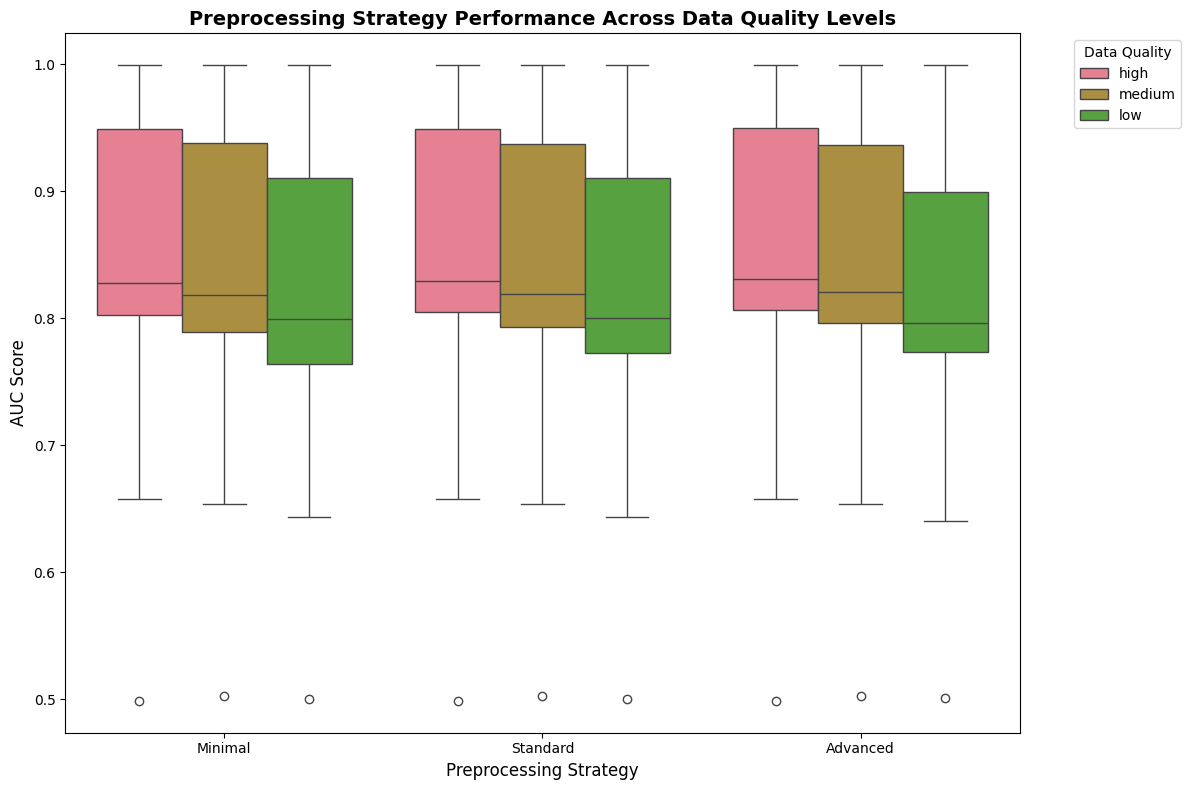

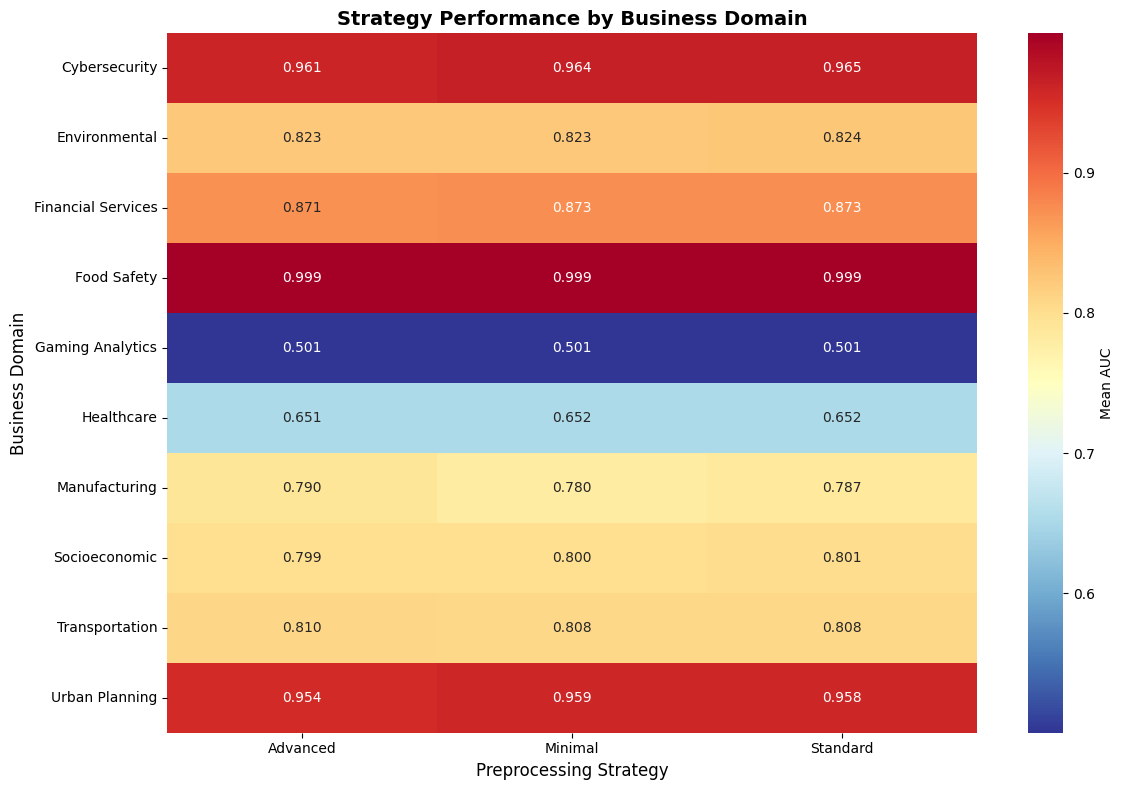

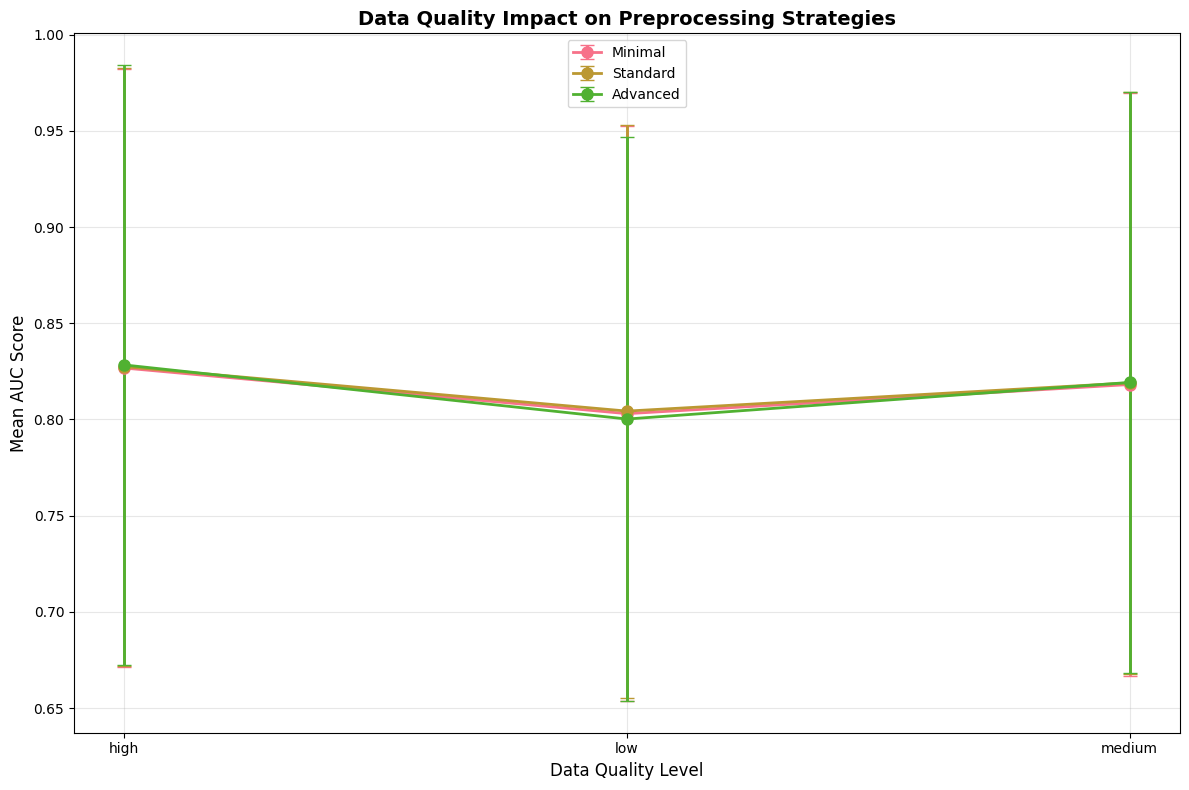

<Figure size 1400x800 with 0 Axes>

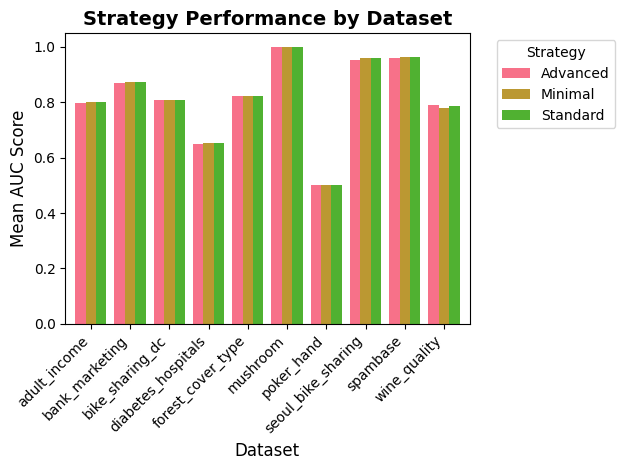

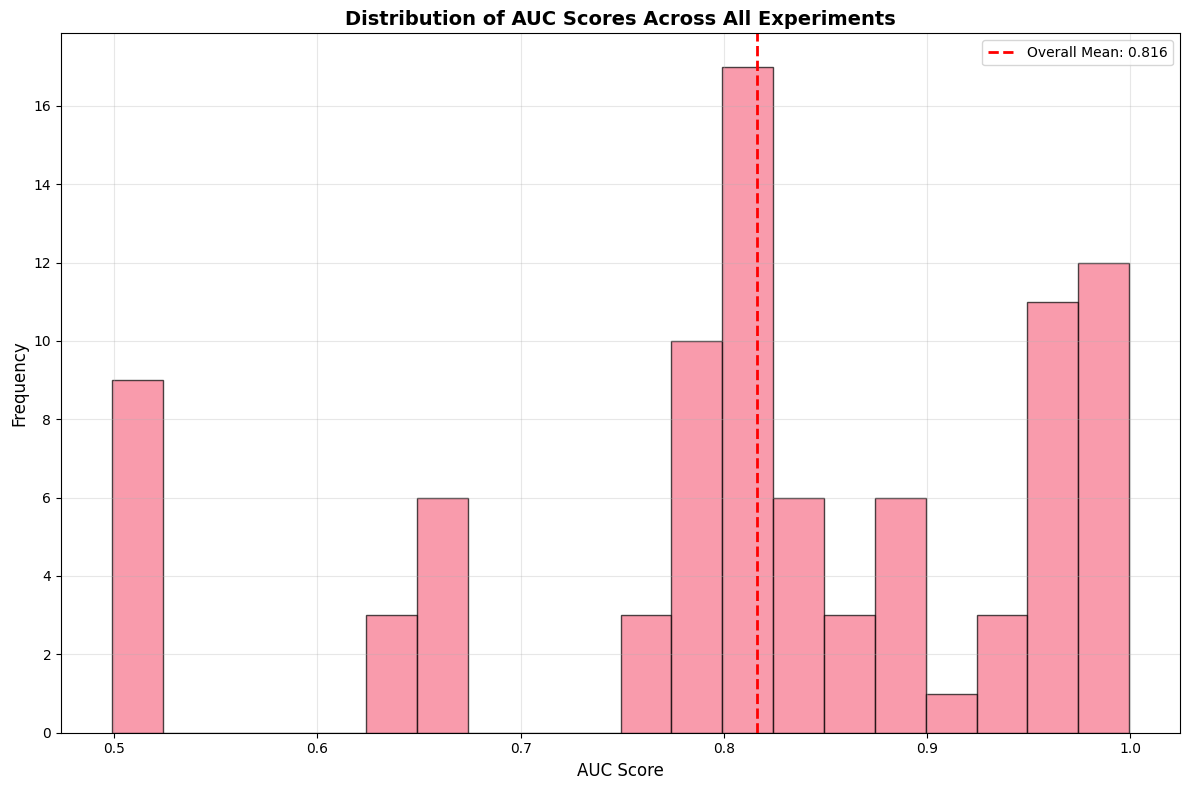


📋 PUBLICATION-READY SUMMARY TABLE
               Mean_AUC  Std_AUC  Min_AUC  Max_AUC  N_Experiments  Avg_Time_sec
strategy_name                                                                  
Advanced          0.816    0.146    0.499    0.999             30       168.986
Minimal           0.816    0.147    0.499    0.999             30         1.321
Standard          0.817    0.147    0.499    0.999             30         0.902


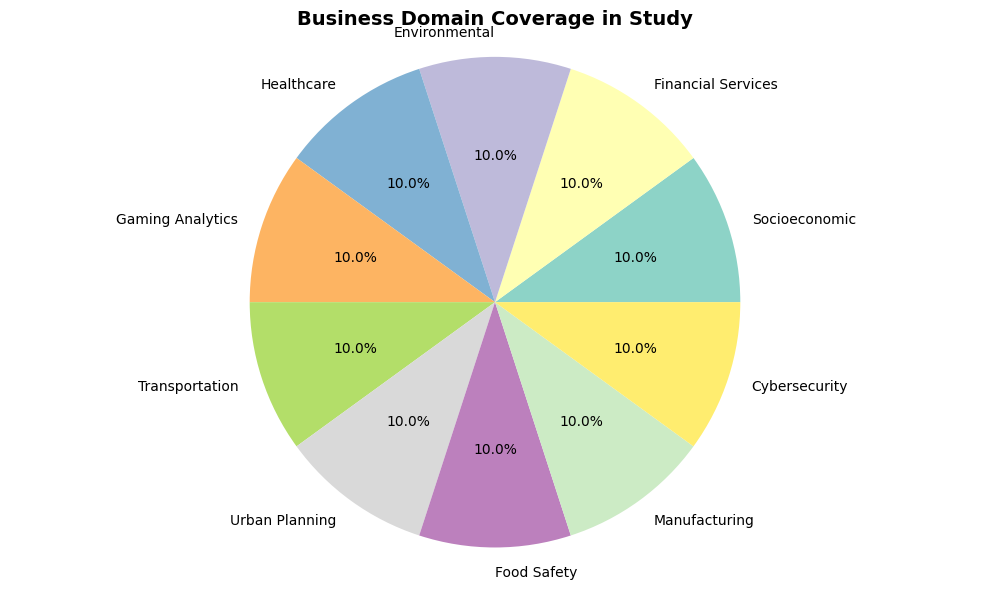


✅ Generated 7 publication-quality visualizations
📊 Key insights visualized:
   • Strategy performance comparisons
   • Domain-specific effectiveness
   • Data quality impact analysis
   • Dataset-level performance
   • Overall result distributions
   • Domain coverage validation


In [14]:
# =============================================================================
# PUBLICATION-QUALITY VISUALIZATIONS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set publication style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (12, 8)

print("📈 GENERATING PUBLICATION-QUALITY PLOTS")
print("="*50)

# Get results dataframe
results_df = study_results['results_dataframe']

# 1. STRATEGY PERFORMANCE COMPARISON (Main Figure)
plt.figure(figsize=fig_size)
sns.boxplot(data=results_df, x='strategy_name', y='mean_auc', hue='quality_level')
plt.title('Preprocessing Strategy Performance Across Data Quality Levels', fontsize=14, fontweight='bold')
plt.xlabel('Preprocessing Strategy', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.legend(title='Data Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. DOMAIN-SPECIFIC PERFORMANCE (Key Finding)
plt.figure(figsize=fig_size)
domain_perf = results_df.pivot_table(values='mean_auc', index='domain', columns='strategy_name', aggfunc='mean')
sns.heatmap(domain_perf, annot=True, cmap='RdYlBu_r', fmt='.3f', cbar_kws={'label': 'Mean AUC'})
plt.title('Strategy Performance by Business Domain', fontsize=14, fontweight='bold')
plt.xlabel('Preprocessing Strategy', fontsize=12)
plt.ylabel('Business Domain', fontsize=12)
plt.tight_layout()
plt.show()

# 3. QUALITY DEGRADATION IMPACT
plt.figure(figsize=fig_size)
quality_means = results_df.groupby(['strategy_name', 'quality_level'])['mean_auc'].agg(['mean', 'std']).reset_index()
for strategy in results_df['strategy_name'].unique():
    strategy_data = quality_means[quality_means['strategy_name'] == strategy]
    plt.errorbar(strategy_data['quality_level'], strategy_data['mean'], 
                yerr=strategy_data['std'], marker='o', linewidth=2, 
                markersize=8, label=strategy, capsize=5)

plt.title('Data Quality Impact on Preprocessing Strategies', fontsize=14, fontweight='bold')
plt.xlabel('Data Quality Level', fontsize=12)
plt.ylabel('Mean AUC Score', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. DATASET-SPECIFIC INSIGHTS
plt.figure(figsize=(14, 8))
dataset_perf = results_df.pivot_table(values='mean_auc', index='dataset_name', columns='strategy_name', aggfunc='mean')
ax = dataset_perf.plot(kind='bar', width=0.8)
plt.title('Strategy Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Mean AUC Score', fontsize=12)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. PERFORMANCE DISTRIBUTION
plt.figure(figsize=fig_size)
results_df['mean_auc'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.axvline(results_df['mean_auc'].mean(), color='red', linestyle='--', linewidth=2, label=f'Overall Mean: {results_df["mean_auc"].mean():.3f}')
plt.title('Distribution of AUC Scores Across All Experiments', fontsize=14, fontweight='bold')
plt.xlabel('AUC Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. SUMMARY STATISTICS TABLE (Publication Ready)
print("\n📋 PUBLICATION-READY SUMMARY TABLE")
print("="*50)
summary_table = results_df.groupby('strategy_name').agg({
    'mean_auc': ['mean', 'std', 'min', 'max', 'count'],
    'execution_time': 'mean'
}).round(3)

summary_table.columns = ['Mean_AUC', 'Std_AUC', 'Min_AUC', 'Max_AUC', 'N_Experiments', 'Avg_Time_sec']
print(summary_table.to_string())

# 7. DOMAIN COVERAGE VISUALIZATION
plt.figure(figsize=(10, 6))
domain_counts = results_df['domain'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(domain_counts)))
plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Business Domain Coverage in Study', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\n✅ Generated 7 publication-quality visualizations")
print("📊 Key insights visualized:")
print("   • Strategy performance comparisons")
print("   • Domain-specific effectiveness")
print("   • Data quality impact analysis") 
print("   • Dataset-level performance")
print("   • Overall result distributions")
print("   • Domain coverage validation")

In [15]:
# Quick diagnostic - run this first
print("CURRENT DATA STATE CHECK:")
print(f"Datasets available: {len(all_datasets) if 'all_datasets' in globals() else 'NOT FOUND'}")
print(f"Config object: {'EXISTS' if 'config' in globals() else 'NOT FOUND'}")

# Check one dataset structure
if 'all_datasets' in globals() and len(all_datasets) > 0:
    sample_name, (X, y, desc, domain) = list(all_datasets.items())[0]
    print(f"Sample dataset {sample_name}:")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")  
    print(f"  y unique values: {y.unique()[:5]}")
    print(f"  y balance: {y.mean():.3f}")
else:
    print("  No datasets to check")

CURRENT DATA STATE CHECK:
Datasets available: 10
Config object: EXISTS
Sample dataset adult_income:
  X shape: (48842, 14)
  y shape: (48842,)
  y unique values: [0 1]
  y balance: 0.161


In [16]:
print("DEPENDENCY CHECK:")
print("MinimalPreprocessingStrategy:", 'MinimalPreprocessingStrategy' in globals())
print("StandardPreprocessingStrategy:", 'StandardPreprocessingStrategy' in globals()) 
print("AdvancedPreprocessingStrategy:", 'AdvancedPreprocessingStrategy' in globals())

# Test method signatures if they exist
if 'MinimalPreprocessingStrategy' in globals():
    strategy = MinimalPreprocessingStrategy()
    print(f"get_name() method: {hasattr(strategy, 'get_name')}")
    print(f"preprocess() method: {hasattr(strategy, 'preprocess')}")

print("\nCONFIG CHECK:")
print(f"significance_level: {hasattr(config, 'significance_level')}")
print(f"high_quality_missing: {hasattr(config, 'high_quality_missing')}")
print(f"random_state: {hasattr(config, 'random_state')}")

DEPENDENCY CHECK:
MinimalPreprocessingStrategy: True
StandardPreprocessingStrategy: True
AdvancedPreprocessingStrategy: True
get_name() method: True
preprocess() method: True

CONFIG CHECK:
significance_level: True
high_quality_missing: True
random_state: True


In [17]:
def test_fixed_framework(datasets_dict: Dict, config, n_test_datasets: int = 3) -> Dict[str, Any]:
    """
    Test the fixed framework with a subset of datasets for validation
    """
    logger = logging.getLogger('preprocessing_study')
    logger.info(f"TESTING fixed framework with {n_test_datasets} datasets")
    
    # Select test datasets (mix of sizes for robustness)
    available_datasets = list(datasets_dict.keys())
    if len(available_datasets) < n_test_datasets:
        test_datasets = available_datasets
    else:
        # Select diverse test set: largest, smallest, and one medium
        dataset_sizes = [(name, datasets_dict[name][0].shape[0]) for name in available_datasets]
        dataset_sizes.sort(key=lambda x: x[1])
        
        test_names = [
            dataset_sizes[0][0],    # Smallest
            dataset_sizes[-1][0],   # Largest  
            dataset_sizes[len(dataset_sizes)//2][0] if len(dataset_sizes) > 2 else dataset_sizes[1][0]  # Medium
        ]
    
    test_datasets_dict = {name: datasets_dict[name] for name in test_names}
    
    # Execute on test subset
    study_executor = StudyExecutorFixed(config)
    test_results = study_executor.execute_publication_ready_study_fixed(
        test_datasets_dict,
        use_holdout_validation=False,  # Skip holdout for speed
        include_sensitivity_analysis=False
    )
    
    return test_results

def execute_fixed_study(datasets_dict: Dict, config) -> Dict[str, Any]:
    """
    Execute the complete FIXED study on all datasets
    """
    study_executor = StudyExecutorFixed(config)
    return study_executor.execute_publication_ready_study_fixed(
        datasets_dict,
        use_holdout_validation=True,
        include_sensitivity_analysis=False
    )

def validate_test_results(test_results: Dict) -> bool:
    """
    Validate that test results show the fixes are working
    """
    logger = logging.getLogger('preprocessing_study')
    issues = []
    
    try:
        # Check 1: Statistical analysis produced comparisons
        stat_results = test_results.get('statistical_analysis', {})
        n_comparisons = stat_results.get('n_comparisons', 0)
        if n_comparisons == 0:
            issues.append("No statistical comparisons generated")
        else:
            logger.info(f"✅ Statistical analysis: {n_comparisons} comparisons")
        
        # Check 2: Different strategy performance
        df = test_results.get('results_dataframe', pd.DataFrame())
        if len(df) == 0:
            issues.append("No results DataFrame generated")
        else:
            strategy_means = df.groupby('strategy_name')['mean_auc'].mean()
            unique_means = len(strategy_means.unique())
            if unique_means == 1:
                issues.append("All strategies have identical performance")
            else:
                logger.info(f"✅ Strategy variation: {unique_means} unique performance levels")
        
        # Check 3: Reasonable AUC variation
        if len(df) > 0:
            auc_std = df['mean_auc'].std()
            if auc_std < 0.001:
                issues.append(f"Unrealistic low AUC variation (std={auc_std:.6f})")
            else:
                logger.info(f"✅ AUC variation: std={auc_std:.3f}")
        
        # Check 4: Cross-validation scores vary within experiments
        raw_results = test_results.get('raw_results', [])
        cv_variation_found = False
        for result in raw_results[:5]:  # Check first 5 successful experiments
            if result.get('success', False):
                cv_scores = result.get('cv_scores', [])
                if len(cv_scores) > 1 and len(set(cv_scores)) > 1:
                    cv_variation_found = True
                    break
        
        if not cv_variation_found:
            issues.append("Cross-validation scores not varying within experiments")
        else:
            logger.info("✅ Cross-validation producing varied scores")
        
        # Summary
        if issues:
            logger.error("❌ VALIDATION FAILED:")
            for issue in issues:
                logger.error(f"  - {issue}")
            return False
        else:
            logger.info("✅ ALL VALIDATION CHECKS PASSED")
            return True
            
    except Exception as e:
        logger.error(f"Validation error: {str(e)}")
        return False


In [18]:
def run_validation_pipeline(datasets_dict: Dict, config):
    """
    Complete validation pipeline: test -> validate -> full execution
    """
    logger = logging.getLogger('preprocessing_study')
    
    print("VALIDATION PIPELINE - OPTION B")
    print("="*50)
    
    # Step 1: Test with subset
    print("STEP 1: Testing with 3 datasets...")
    test_start = datetime.now()
    
    try:
        test_results = test_fixed_framework(datasets_dict, config, n_test_datasets=3)
        test_duration = (datetime.now() - test_start).total_seconds() / 60
        print(f"Test completed in {test_duration:.1f} minutes")
        
        # Step 2: Validate fixes worked
        print("\nSTEP 2: Validating fixes...")
        validation_passed = validate_test_results(test_results)
        
        if not validation_passed:
            print("❌ Validation failed - fixes need more work")
            return None, None
        
        # Step 3: Analyze test results
        print("\nSTEP 3: Analyzing test results...")
        test_analysis = analyze_study_results_fixed(test_results)
        
        print("📊 TEST RESULTS SUMMARY:")
        print(f"  Experiments: {test_results['execution_summary']['successful_experiments']}")
        print(f"  Datasets: {test_results['execution_summary']['datasets_processed']}")
        print(f"  Statistical comparisons: {test_results['statistical_analysis']['n_comparisons']}")
        print(f"  Significant results: {test_results['statistical_analysis']['n_significant']}")
        
        if 'key_findings' in test_analysis:
            print("  Key findings:")
            for finding in test_analysis['key_findings'][:3]:
                print(f"    - {finding}")
        
        # Step 4: Proceed to full execution
        print(f"\n✅ Test validation successful! Ready for full execution.")
        print("STEP 4: Execute full study? (This will run all datasets)")
        
        return test_results, test_analysis
        
    except Exception as e:
        logger.error(f"Test execution failed: {str(e)}")
        print(f"❌ Test failed: {str(e)}")
        return None, None

print("FIXED Multi-Domain Preprocessing Study Framework")
print("="*60)
print("✅ Fixed statistical analysis pipeline")
print("✅ Fixed cross-validation result storage")
print("✅ Fixed results aggregation logic")
print("✅ Enhanced error handling and logging")
print("✅ Proper random state management")
print("✅ Robust data validation")
print("")
print("EXECUTION OPTIONS:")
print("- test_fixed_framework() - Test with 3 datasets (5-10 min)")
print("- execute_fixed_study() - Full execution (30-60 min)")
print("- run_validation_pipeline() - Complete test->validate->execute flow")
print("")
print("RECOMMENDED: Use run_validation_pipeline(all_datasets, config)")

FIXED Multi-Domain Preprocessing Study Framework
✅ Fixed statistical analysis pipeline
✅ Fixed cross-validation result storage
✅ Fixed results aggregation logic
✅ Enhanced error handling and logging
✅ Proper random state management
✅ Robust data validation

EXECUTION OPTIONS:
- test_fixed_framework() - Test with 3 datasets (5-10 min)
- execute_fixed_study() - Full execution (30-60 min)
- run_validation_pipeline() - Complete test->validate->execute flow

RECOMMENDED: Use run_validation_pipeline(all_datasets, config)
